# Power Plant Energy Output Prediction : Weekend Hackathon #13

The dataset was collected from a Combined Cycle Power Plant over 6 years (2006-2011) when the power plant was set to work with a full load. Features consist of hourly average ambient variables Temperature (T), Ambient Pressure (AP), Relative Humidity (RH), and Exhaust Vacuum (V) to predict the net hourly electrical energy output (PE) of the plant.
A combined-cycle power plant (CCPP) is composed of gas turbines (GT), steam turbines (ST), and heat recovery steam generators.

In a CCPP, the electricity is generated by gas and steam turbines, which are combined in one cycle, and is transferred from one turbine to another. While the Vacuum is collected from and has an effect on the Steam Turbine, the other three of the ambient variables affect the GT performance.

Attribute Information:

Features consist of hourly average ambient variables

-Temperature (T) in the range 1.81°C and 37.11°C
-Ambient Pressure (AP) in the range 992.89-1033.30 millibar
-Relative Humidity (RH) in the range of 25.56% to 100.16%
-Exhaust Vacuum (V) in the range 25.36-81.56 cm Hg
-Net hourly electrical energy output (PE) 420.26-495.76 MW

Link to LB: https://www.machinehack.com/hackathons/power_plant_energy_output_prediction_weekend_hackathon_13

# Rank:19

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("fivethirtyeight")
from pylab import rcParams

import warnings
warnings.filterwarnings("ignore")

import os
os.chdir("C:\\Users\\Ram RS\\Documents\\python\\CCPP_participants_Data")

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor

In [2]:
train = pd.read_csv("Train.csv")
test = pd.read_csv("Test.csv")

# EDA

In [3]:
print(train.shape , test.shape)

(9568, 5) (38272, 4)


In [4]:
train.head()

,AT,V,AP,RH,PE
0,29.07,72.51,1009.24,58.38,449.371855
1,32.38,67.17,1006.97,60.04,450.861043
2,19.29,67.71,1007.94,63.71,460.894029
3,16.45,41.48,1016.64,45.21,467.577314
4,21.43,46.97,1013.94,61.25,469.805723


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9568 entries, 0 to 9567
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      9568 non-null   float64
 1   V       9568 non-null   float64
 2   AP      9568 non-null   float64
 3   RH      9568 non-null   float64
 4   PE      9568 non-null   float64
dtypes: float64(5)
memory usage: 373.9 KB


In [6]:
target = train["PE"]
trainx = train.drop("PE",axis=1)

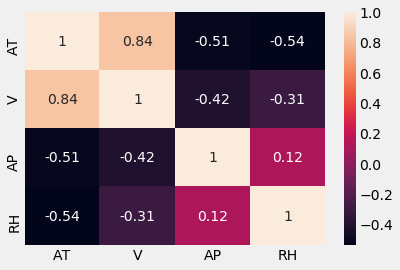

In [7]:
sns.heatmap(trainx.corr(),annot=True)

# Distribution of Target

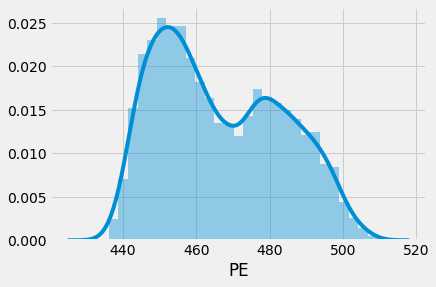

In [8]:
sns.distplot(target)

In [13]:
from scipy.stats import skew
print("skewb: ",skew(target))

skewb:  0.32224558210697923


In [14]:
logx = np.log(target)
print("skewa: ",skew(logx))

skewa:  0.27549862535904124


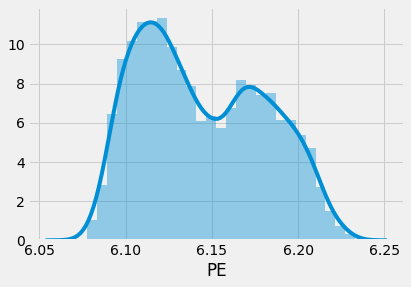

In [19]:
sns.distplot(logx)

Only a slight change target before transform itself seems to normal.

# Feature Engineering

In [79]:
df = pd.concat([trainx,test],axis=0)

In [80]:
df.shape

(47840, 4)

1.Lets say ambient pressure by exausht vaccum

In [81]:
df["AP/V"] = df["AP"] / df["V"]

2. Getting realtion between Pressure and temperature through.. pressure/Temperature

In [82]:
df["AP/AT"] = df["AP"] / df["AT"]

In [83]:
#Converting Ambient pressure to a higher dimension(polynomial)
#df["AP**6"] = df["AP"]**4

# Correlation PLOT

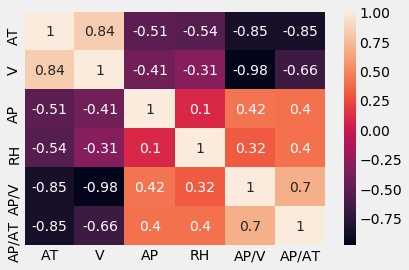

In [84]:
sns.heatmap(df.corr(),annot=True)

In [85]:
#del df["AT"]

# Scaling of independent variables

In [86]:
scaler = StandardScaler()
scaler_array = scaler.fit_transform(df)
df_fi = pd.DataFrame(scaler_array, columns = df.columns)

In [87]:
X_Tr = df_fi[:trainx.shape[0]]
X_Te = df_fi[trainx.shape[0]:]

In [88]:
X_Tr = X_Tr.values
X_Te = X_Te.values
Y = target.values

# Partition

In [89]:
train_x,test_x,train_y,test_y = train_test_split(X_Tr,Y,test_size = 0.30)

# Model

In [90]:
xgb = XGBRegressor(learning_rate=0.08, max_depth=31,
             min_child_weight=3, n_estimators=150, subsample=0.8)
xgb.fit(train_x, train_y)
pred_xgb = xgb.predict(test_x)
np.sqrt(mean_squared_error(test_y, pred_xgb))

2.6120067155608986

lgbm = LGBMRegressor(n_estimators=100, max_depth=31,min_child_samples=3,
                      learning_rate=0.09)
lgbm.fit(train_x, train_y)
pred_lgbm = lgbm.predict(test_x)
np.sqrt(mean_squared_error(test_y,pred_lgbm))

# XGB Feature importance

In [91]:
fe_imp = pd.DataFrame()
fe_imp["Features"],fe_imp["Importance"] = df_fi.columns, xgb.feature_importances_

In [92]:
fe_imp

,Features,Importance
0,AT,0.090004
1,V,0.049571
2,AP,0.005792
3,RH,0.004744
4,AP/V,0.098417
5,AP/AT,0.751472


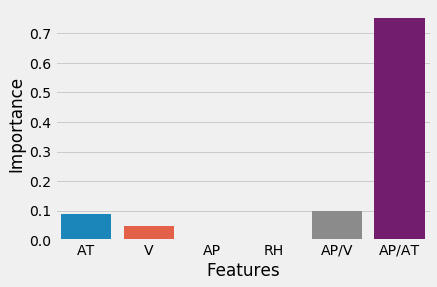

In [93]:
sns.barplot(y=fe_imp["Importance"],x=fe_imp["Features"])

# KFOLD to know better consistency of the model

In [94]:
result = []

fold = KFold(n_splits=10, shuffle=True, random_state=100)
j = 1
for train_index, test_index in fold.split(X_Tr, target):
    #partition
    x_train, x_val = X_Tr[train_index], X_Tr[test_index]
    y_train, y_val = target.iloc[train_index], target.iloc[test_index]
    #model
    Xgb = XGBRegressor(learning_rate=0.07, max_depth=31,
             min_child_weight=3, n_estimators=150, subsample=0.8,objective="reg:squarederror")
    Xgb.fit(x_train, y_train)
    pred_y = Xgb.predict(x_val)
    #RMSE
    print(j, " err_grb: ", np.sqrt(mean_squared_error(y_val,pred_y)))
    result.append(np.sqrt(mean_squared_error(y_val,pred_y)))
    j = j + 1    
print()
print("XGB Mean RMSE : ", np.mean(result))

1  err_grb:  2.2961191906082137
2  err_grb:  2.3193468189892026
3  err_grb:  2.4182223582918523
4  err_grb:  2.8564535919890597
5  err_grb:  2.25367936736131
6  err_grb:  2.390699414744269
7  err_grb:  2.225859811127615
8  err_grb:  2.9466825882845584
9  err_grb:  2.6021289811960244
10  err_grb:  2.396773697000518

XGB Mean RMSE :  2.4705965819592626


# FINAL Submit

In [530]:
XGB = XGBRegressor(learning_rate=0.07, max_depth=31,
             min_child_weight=3, n_estimators=150, subsample=0.8,objective="reg:squarederror")
XGB.fit(X_Tr, Y)
pred_XGB = XGB.predict(X_Te)

In [531]:
sub = pd.DataFrame(pred_XGB,columns=["PE"])

In [532]:
sub.head()

,PE
0,472.799530
1,495.221344
2,497.341003
3,479.640167
4,445.429871


In [533]:
sub.to_csv("p17.csv",index=False)

# THANK YOU..!